## Spectrogram Visualizer
The following notebook enables one to visualize the spectrogram he/she will get during trainig. This code aims to mimic the "getitem" functionalities, and show the spectrogram the model gets

In [1]:
import sys
from pathlib import Path
import yaml
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
from pprint import pprint
import torch
import librosa.display


sys.path.append('..')

In [2]:
from soundbay.data import ClassifierDataset

In [3]:
import hydra

In [4]:
import sys
sys.version

'3.9.1 (tags/v3.9.1:1e5d33e, Dec  7 2020, 17:08:21) [MSC v.1927 64 bit (AMD64)]'

In [5]:
## utils

class DotDictWrapper:
    """
    d['key']==d.key
    """
    def __init__(self, d):
        self._dict = d

    def __getattr__(self, name):
        if name in self._dict:
            return self._dict[name]
        else:
            raise AttributeError(f"'{type(self).__name__}' object has no attribute '{name}'")

    def __getitem__(self, key):
        return self._dict[key]

### Your params here

In [88]:
DATA_PATH = r'C:\Users\amitg\Documents\Deep_Voice\HF_WAV_Manatee_Samples\2022-06-22-reproject\Acoustic_recordings'
METADATA_PATH = r'C:\Users\amitg\Documents\Deep_Voice\HF_WAV_Manatee_Samples\2022-06-22-reproject\manatee_2022_train_val_test_splits_80_20.csv'

# load augmentation and preprocessors - you can choose what yaml file to load by changing the path below
with open('../soundbay/conf/preprocessors/_mel_preprocessors.yaml', 'r') as file:
    preprocessors = yaml.safe_load(file)
with open('../soundbay/conf/augmentations/_augmentations.yaml', 'r') as file:
    augmentations = yaml.safe_load(file)
with open('../soundbay/conf/data/Manatees.yaml', 'r') as file:
    data = yaml.safe_load(file)
    
data = data['data']
preprocessors=preprocessors['_preprocessors']
augmentations = augmentations['_augmentations']

In [89]:
pprint(data)
# print(preprocessors)

{'batch_size': 32,
 'data_sample_rate': 96000,
 'hop_length': 256,
 'label_names': ['Noise', 'Call'],
 'max_freq': 44100,
 'min_freq': 0,
 'n_fft': 1024,
 'num_workers': 4,
 'sample_rate': 96000,
 'train_dataset': {'_target_': 'soundbay.data.ClassifierDataset',
                   'augmentations': '${_augmentations}',
                   'augmentations_p': 0.8,
                   'data_path': '../datasets/Manatees/train_data/wav',
                   'data_sample_rate': '${data.data_sample_rate}',
                   'len_buffer': 0.1,
                   'margin_ratio': 0,
                   'metadata_path': '../datasets/Manatees/Manatee_train_val_splits.csv',
                   'mode': 'train',
                   'preprocessors': '${_preprocessors}',
                   'sample_rate': '${data.sample_rate}',
                   'seq_length': 0.2,
                   'slice_flag': False,
                   'split_metadata_by_label': True},
 'val_dataset': {'_target_': 'soundbay.data.Classifier

In [90]:
## you can tune the parameters from here, or you can change them in the yaml files and then load again
print(f"before: {data['data_sample_rate']}")
data['data_sample_rate'] = 96000
print(f"after: {data['data_sample_rate']}")

before: 96000
after: 96000


In [91]:
aggr_conf = OmegaConf.create({'data':data, 'preprocessors':preprocessors, 'augmentations':augmentations})

In [92]:
cfg = DotDictWrapper({
    'data_path': DATA_PATH,
    'metadata_path': METADATA_PATH,
    'augmentations': aggr_conf.augmentations,
    'augmentations_p': aggr_conf.data.train_dataset.augmentations_p,
    'preprocessors': aggr_conf.preprocessors,
    'seq_length': aggr_conf.data.train_dataset.seq_length,
    'data_sample_rate': aggr_conf.data.data_sample_rate,
    'sample_rate': aggr_conf.data.sample_rate,
    'mode': "train",
    'slice_flag': False,
    'margin_ratio': 0,
    'split_metadata_by_label': False,
})

# cfg_val = ... 

# initiate the dataset

dataset_train = ClassifierDataset(cfg.data_path, cfg.metadata_path, cfg.augmentations, cfg.augmentations_p, cfg.preprocessors,
                 cfg.seq_length, cfg.data_sample_rate, cfg.sample_rate, cfg.mode,
                 cfg.slice_flag, cfg.margin_ratio, cfg.split_metadata_by_label)

C:\Users\amitg\soundbay39venv\lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(


In [93]:
dataset_train.metadata.head()

,Selection,View,channel,begin_time,end_time,Low Freq (Hz),High Freq (Hz),Delta Time (s),Delta Freq (Hz),Avg Power Density (dB FS/Hz),...,PFC Min Freq (Hz),Max Freq (Hz),Annotation,filename,StartMicInWater,EndMicInWater,filepath,label,call_length,split_type
0,2,Spectrogram 1,1,13.317047,17.681407,3000.0,4350.0,0.1964,1350.0,-46.62,...,3375.0,3562.5,Y,211127_0066,13.213609,36.835417,annotations,0,4.364360,test
1,3,Spectrogram 1,1,17.877805,18.947378,3900.0,5475.0,0.2248,1575.0,-38.94,...,4125.0,5062.5,Y,211127_0066,13.213609,36.835417,annotations,0,1.069572,test
2,4,Spectrogram 1,1,19.172220,24.293471,2400.0,3900.0,0.1314,1500.0,-56.70,...,2625.0,3375.0,N,211127_0066,13.213609,36.835417,annotations,0,5.121251,test
3,5,Spectrogram 1,1,24.424855,26.460742,4500.0,6225.0,0.2262,1725.0,-48.95,...,4875.0,5437.5,Y,211127_0066,13.213609,36.835417,annotations,0,2.035887,test
4,6,Spectrogram 1,1,26.686939,32.289177,2625.0,3900.0,0.2790,1275.0,-59.71,...,2625.0,3750.0,N,211127_0066,13.213609,36.835417,annotations,0,5.602238,test


___
---

### Functionalities from getitem

In [94]:
"""
__getitem__ method loads item according to idx from the metadata
path_to_file, begin_time, end_time, label, channel = self._grab_fields(idx)
audio = self._get_audio(path_to_file, begin_time, end_time, label, channel)
audio_raw = self.sampler(audio)
audio_augmented = self.augment(audio_raw)
audio_processed = self.preprocessor(audio_augmented)
"""

'\n__getitem__ method loads item according to idx from the metadata\npath_to_file, begin_time, end_time, label, channel = self._grab_fields(idx)\naudio = self._get_audio(path_to_file, begin_time, end_time, label, channel)\naudio_raw = self.sampler(audio)\naudio_augmented = self.augment(audio_raw)\naudio_processed = self.preprocessor(audio_augmented)\n'

In [95]:
def show_spectrogram(audio_processed, title, label):
    plt.figure()
    librosa.display.specshow(audio_processed)
    plt.title(f"{str(title)} label: {label}")
    plt.show()

In [98]:
indices_to_check = [1,13,1602]

audio.shape: torch.Size([1, 19200])
audio_raw.shape: torch.Size([1, 19200])
audio_augmented.shape: torch.Size([1, 19200])
audio_processed.shape: torch.Size([1, 128, 76])


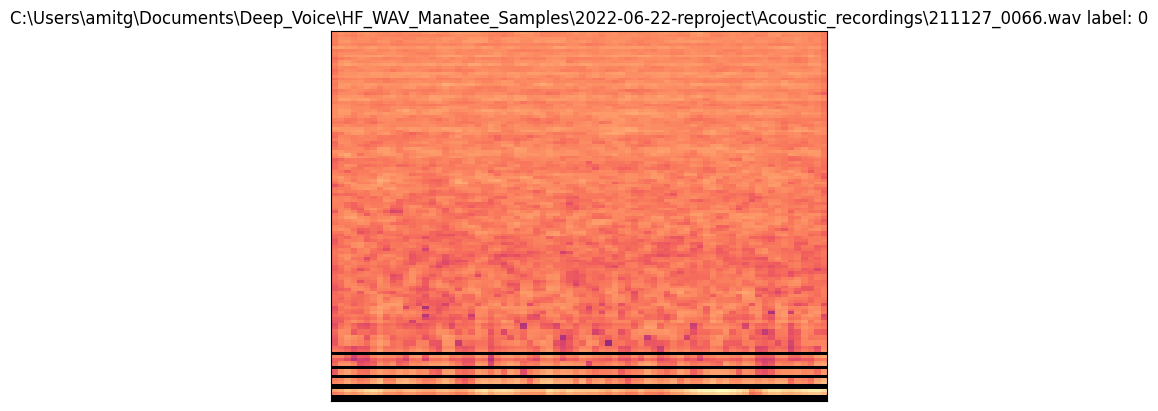

audio.shape: torch.Size([1, 19200])
audio_raw.shape: torch.Size([1, 19200])
audio_augmented.shape: torch.Size([1, 19200])
audio_processed.shape: torch.Size([1, 128, 76])


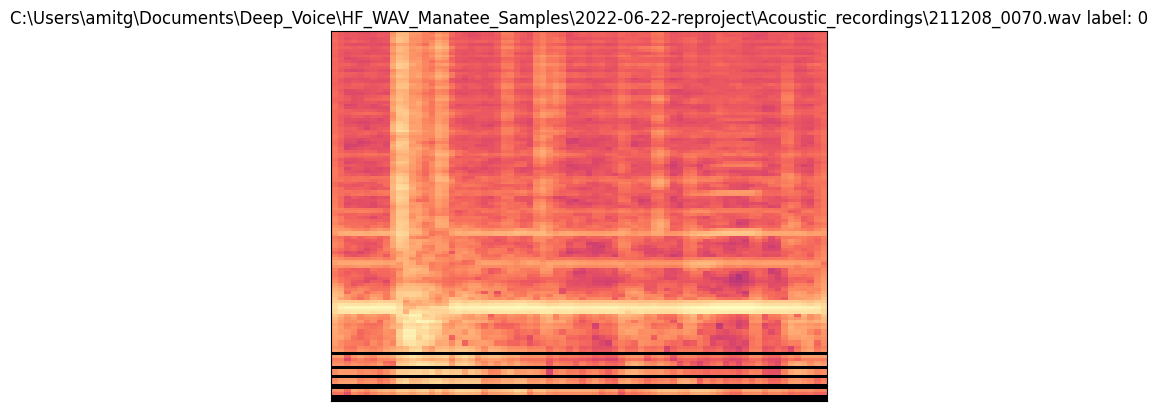

audio.shape: torch.Size([1, 19200])
audio_raw.shape: torch.Size([1, 19200])
audio_augmented.shape: torch.Size([1, 19200])
audio_processed.shape: torch.Size([1, 128, 76])


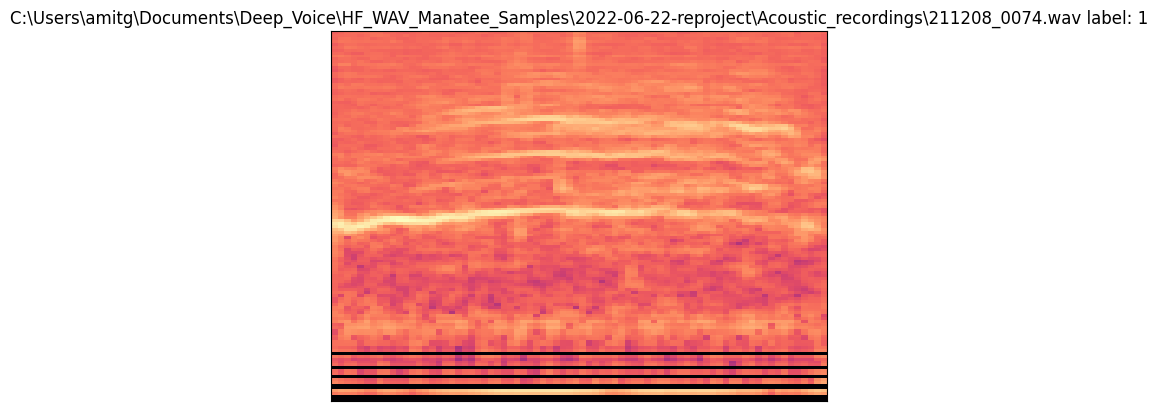

In [99]:
for idx in indices_to_check:
    path_to_file, begin_time, end_time, label, channel = dataset_train._grab_fields(idx)
    audio = dataset_train._get_audio(path_to_file, begin_time, end_time, label, channel)
    print(f"audio.shape: {audio.shape}")
    audio_raw = dataset_train.sampler(audio)
    print(f"audio_raw.shape: {audio_raw.shape}")
    audio_augmented = dataset_train.augment(audio_raw)
    print(f"audio_augmented.shape: {audio_augmented.shape}")
    audio_processed = dataset_train.preprocessor(audio_augmented)
    print(f"audio_processed.shape: {audio_processed.shape}")
    
    audio_processed = audio_processed.squeeze().cpu().numpy()
    show_spectrogram(audio_processed, title=path_to_file, label=label)